<a href="https://colab.research.google.com/github/jimmypocock/fastai-course-projects/blob/main/01-image-recognition/dog_breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤟 Dog Breed Recognition with FastAI

**Project:** Dog Breed Classification Using IMAGEWOOF
**Framework:** FastAI v2.7+ / PyTorch
**Author:** Jimmy Pocock
**Date:** October 2025

---

## 📋 Project Overview

Building a dog breed recognition system using FastAI's high-level APIs. This project demonstrates:
- FastAI's DataBlock API for data preparation
- Transfer learning with vision_learner
- Fine-tuning pretrained models
- Achieving >90% accuracy with minimal code

**IMAGEWOOF Dataset Stats:**

- Number of classes: 10 dog breeds
- Total images: ~12,000-13,000 images (exact number varies by version)
- Train/validation split: 70/30
- Image sizes available: Full size, 320px, or 160px versions

**The breeds:**
1. Australian Terrier
2. Border Terrier
3. Samoyed
4. Beagle
5. Shih-Tzu
6. English Foxhound
7. Rhodesian Ridgeback
8. Dingo
9. Golden Retriever
10. Old English Sheepdog

**Why it's challenging:** Multiple terrier breeds, and several breeds that can look similar (especially at different angles/ages)

**Goal:** Build a classifier that can recognize dog breeds in real-time

---

## 🛠️ Setup and Installation

First, we'll install FastAI and import the vision library which includes all the tools we need for image classification.

In [1]:
# Install and setup
!pip install -Uqq fastai
from fastai.vision.all import *

## 📥 Download Dataset

We'll download the IMAGEWOOF-320 dataset, which contains images resized to 320px for faster training.

In [2]:
path = untar_data(URLs.IMAGEWOOF_320)
print(f"Dataset location: {path}")

# Check how many training images we have
files = get_image_files(path/"train")
print(f"Number of training images: {len(files)}")

Dataset location: /Users/jimmypocock/.fastai/data/imagewoof2-320
Number of training images: 9025


## 🔍 Explore the Data

Let's look at the structure and see some sample images.

In [3]:
# Take a look at available paths
path.ls()

(#3) [Path('/Users/jimmypocock/.fastai/data/imagewoof2-320/train'),Path('/Users/jimmypocock/.fastai/data/imagewoof2-320/noisy_imagewoof.csv'),Path('/Users/jimmypocock/.fastai/data/imagewoof2-320/val')]

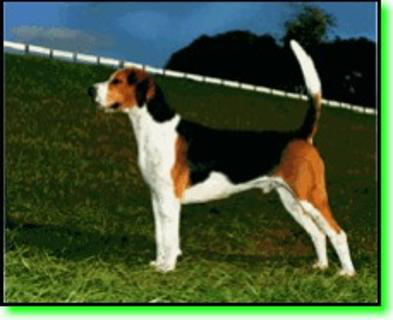

In [4]:
# Take a look at an image from the dataset
Image.open(files[0])

## 🗂️ Prepare DataLoaders

DataLoaders tell the model how to load images and their labels. Since images are organized in folders by breed name, we'll use `from_folder()`.

In [5]:
# Breed mapping - ImageNet synset codes mapped to breed names (derived from dataset folder structure):
# Dataset source: https://github.com/fastai/imagenette
breed_map = {
    'n02086240': 'Shih-Tzu',
    'n02087394': 'Rhodesian Ridgeback',
    'n02088364': 'Beagle',
    'n02089973': 'English Foxhound',
    'n02093754': 'Border Terrier',
    'n02096294': 'Australian Terrier',
    'n02099601': 'Golden Retriever',
    'n02105641': 'Old English Sheepdog',
    'n02111889': 'Samoyed',
    'n02115641': 'Dingo'
}

# Function to get breed name from file path
def get_breed(fname): 
  return breed_map[fname.parent.name]

print(f"Sample label: {get_breed(files[0])}")

Sample label: English Foxhound


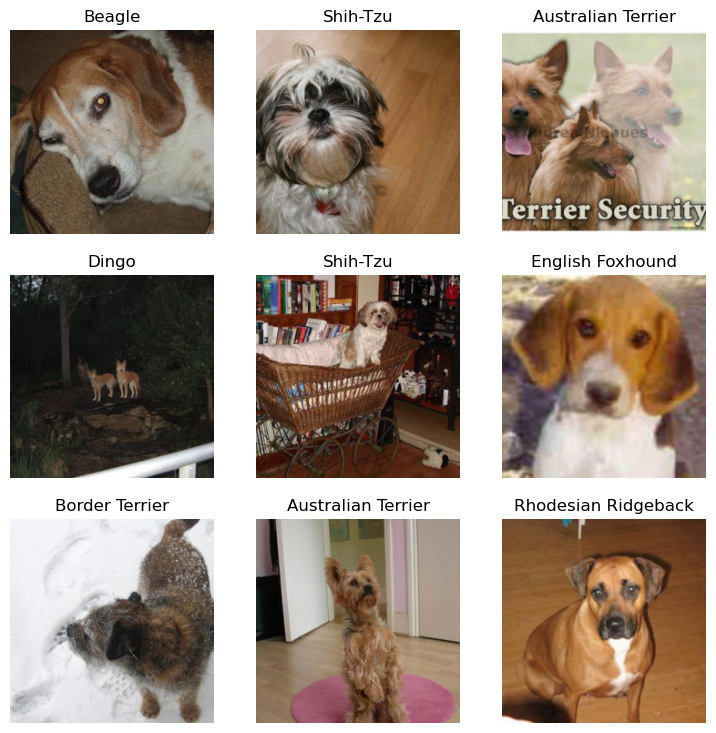

In [6]:
dls = ImageDataLoaders.from_path_func(
  path, 
  get_image_files(path), 
  valid_pct=0.2, 
  seed=42,
  label_func=get_breed, 
  item_tfms=Resize(224))

# Show a batch of images with their labels
dls.show_batch(max_n=9, nrows=3)

## 🧠 Create and Train the Model

We'll use transfer learning with ResNet-34, a pretrained model that already knows how to recognize image features. We'll fine-tune it to recognize our specific dog breeds.

## 🧠 Create and Train the Model

We'll use transfer learning with ResNet-34, a pretrained model that already knows how to recognize image features. We'll fine-tune it to recognize our specific dog breeds.

### 🔬 Experiment: Manual Freeze/Unfreeze vs fine_tune()

**What we're testing:** Two approaches to transfer learning
1. **Manual approach:** Freeze → train → unfreeze → train
2. **FastAI's fine_tune():** Does it automatically

**Watch the results carefully!** You might expect similar performance, but there's a critical difference in how learning rates are applied...

In [11]:
# Train just the new final layer (1 epoch)
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.freeze()  # Keep pretrained weights frozen
learn.fit_one_cycle(1)
print(f"Error rate with frozen backbone: {learn.validate()[1]:.4f}")

learn.unfreeze()
learn.fit_one_cycle(1)
print(f"Error rate after fine-tuning: {learn.validate()[1]:.4f}")

epoch,train_loss,valid_loss,error_rate,time
0,0.379536,0.179190,0.054440,16:03


Error rate with frozen backbone: 0.0544


epoch,train_loss,valid_loss,error_rate,time
0,0.792382,0.438321,0.148263,06:23


Error rate after fine-tuning: 0.1483


### 😱 Wait... Performance Got WORSE After Unfreezing?!

**Results:**
- Frozen backbone: **94.5% accuracy** (5.4% error)
- After unfreezing: **85.2% accuracy** (14.8% error) ❌

**What went wrong?** This seems backwards! Unfreezing should let us fine-tune MORE of the model, so why did accuracy DROP by 9%?

**The Problem: Uniform Learning Rates**

When we call `learn.fit_one_cycle(1)` after unfreezing:
- **ALL layers get the SAME learning rate** (whatever the default is, typically ~1e-3)
- The early pretrained layers contain valuable ImageNet features (edges, textures, shapes)
- Hitting these with a high learning rate **destroys** those carefully pretrained weights
- It's like taking a Renaissance painting and letting a toddler "improve" it with crayons

**What we needed:** Different learning rates for different layers
- Early layers (pretrained): tiny learning rate (~1e-6) to preserve features
- Later layers (dog-specific): higher learning rate (~1e-4) to adapt

**The fix:** Use discriminative learning rates with `slice()`:
```python
learn.unfreeze()
learn.fit_one_cycle(1, lr_max=slice(1e-6, 1e-4))  # Early: 1e-6, Late: 1e-4
```

But there's an easier way... 👇

In [9]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.446044,0.196850,0.062934,04:17


epoch,train_loss,valid_loss,error_rate,time
0,0.286477,0.201299,0.063707,06:11


### ✅ The fine_tune() Solution

**What fine_tune() does automatically:**

1. **Freezes** the pretrained backbone
2. **Trains** the new head (1 epoch by default)
3. **Unfreezes** all layers
4. **Applies discriminative learning rates** using `slice()`
   - Early layers: very small LR (protects pretrained features)
   - Later layers: higher LR (adapts to dog breeds)
5. **Trains** the whole model

**Key Insight:** `fine_tune()` is NOT just a convenience wrapper—it's doing something fundamentally different than manual freeze/unfreeze with uniform learning rates.

**Expected results:**
- Should match or exceed the frozen-only accuracy (~94.5%)
- Typically achieves **93-95% accuracy** on IMAGEWOOF
- Much better than manual unfreeze without discriminative LRs (85%)

**When to use each approach:**

| Method | Use When |
|--------|----------|
| `fine_tune()` | Default choice—handles discriminative LRs automatically |
| Manual freeze/unfreeze | You want fine-grained control over epochs, LRs, callbacks |
| Manual + `slice()` | You understand discriminative LRs and have a specific strategy |

**Bottom line:** Unless you have a specific reason to do otherwise, use `fine_tune()`—it embodies best practices that took the community years to discover.

---

## QUESTIONNAIRE ANSWERS

Based on the notebook content, I'll answer the questions from both the Questionnaire and Further Research sections:

**Questionnaire:**

1. **Do you need lots of math to do deep learning?** 
  - No, just high school math is sufficient. The book emphasizes that deep learning is accessible without advanced mathematics.

2. **Do you need lots of data to do deep learning?** 
  - No, the book mentions seeing record-breaking results with fewer than 50 items of data. Transfer learning allows us to work with small datasets.

3. **Do you need expensive computers to do deep learning?** 
  - No, you can get what you need for state-of-the-art work for free through cloud services like Google Colab.

4. **Name five areas where deep learning is now the best in the world:** 
  - Natural Language Processing (answering questions, speech recognition)
  - Computer Vision (face recognition, satellite imagery interpretation)
  - Medicine (finding anomalies in radiology images)
  - Biology (protein folding, genomics tasks)
  - Game Playing (chess, Go, Atari games)

5. **What was the name of the first device that was based on the principle of the artificial neuron?** 
  - The Mark I Perceptron, built by Frank Rosenblatt.

6. **Based on the book of the same name, what are the requirements for parallel distributed processing (PDP)?**
  - A set of processing units
  - A state of activation
  - An output function for each unit
  - A pattern of connectivity among units
  - A propagation rule for propagating patterns
  - An activation rule for combining inputs
  - A learning rule for modifying connections
  - An environment within which the system operates

7. **What were the two theoretical misunderstandings that held back the field of neural networks?** 
  - First: Only recognizing that single-layer networks couldn't learn XOR, not the solution of using multiple layers
  - Second: Not appreciating that deeper networks (more than 2 layers) were needed for practical performance

8. **What is a GPU?**
  - Graphics Processing Unit - a special processor that can handle thousands of single tasks simultaneously, originally designed for gaming but perfect for neural networks.

9.  **Open a notebook and execute a cell containing: `1+1`. What happens?** 
  - Jupyter displays the output `2` below the cell.

10. **Follow through each cell of the stripped version of the notebook for this chapter. Before executing each cell, guess what will happen.** 
  - This requires hands-on practice with the notebook.

11. **Complete the Jupyter Notebook online appendix.** 
  - This is a practical exercise to be completed separately.

12. **Why is it hard to use a traditional computer program to recognize images in a photo?** 
  - Traditional programs work very differently from brains and struggle with tasks that brains find easy, like pattern recognition and dealing with variations.

13. **What did Samuel mean by "weight assignment"?** 
  - The parameters that the model learns during training to make predictions.

14. **What term do we normally use in deep learning for what Samuel called "weights"?** 
  - Parameters or weights (still used today).

15. **Draw a picture that summarizes Samuel's view of a machine learning model.** 
  - Input → Model (with weights/parameters) → Output, with feedback loop for training.

16. **Why is it hard to understand why a deep learning model makes a particular prediction?** 
  - The model uses many layers of neurons with complex interactions between millions of parameters.

17. **What is the name of the theorem that shows that a neural network can solve any mathematical problem to any level of accuracy?**  
  - The Universal Approximation Theorem.

18. **What do you need in order to train a model?** 
  - Data (inputs and labels), a model architecture, a loss function, and an optimization algorithm.

19. **How could a feedback loop impact the rollout of a predictive policing model?** 
  - It could create bias amplification where predictions lead to more policing in certain areas, generating more arrests, reinforcing the original bias.

20. **Do we always have to use 224×224-pixel images with the cat recognition model?** 
  - No, this is just a common size for pretrained models, but you can use different sizes.

21. **What is the difference between classification and regression?** 
  - Classification predicts categories/classes, regression predicts continuous numerical values.

22. **What is a validation set? What is a test set? Why do we need them?** 
  - Validation set: used during training to evaluate model performance and tune hyperparameters. 
  - Test set: held out to evaluate final model performance. We need them to detect overfitting.

23. **What will fastai do if you don't provide a validation set?** 
  - It will automatically create one, typically using 20% of the training data.

24. **Can we always use a random sample for a validation set? Why or why not?** 
  - No, not always. For time series data, you need chronological splits. For some problems, you need to ensure the validation set represents the deployment scenario.

25. **What is overfitting? Provide an example.** 
  - When a model memorizes training data instead of learning general patterns. Example: A model that perfectly classifies training images but fails on new photos.

26. **What is a metric? How does it differ from loss?** 
  - A metric measures model performance for humans to understand (like accuracy). Loss is what the model optimizes during training and must be differentiable.

27. **How can pretrained models help?** 
  - They provide learned features from large datasets that can be fine-tuned for your specific task, requiring less data and training time.

28. **What is the "head" of a model?** 
  - The final layer(s) that are specific to your task, replaced when fine-tuning a pretrained model.

29. **What kinds of features do the early layers of a CNN find? How about the later layers?** 
  - Early layers find simple features like edges and textures. Later layers find complex patterns like objects and concepts.

30. **Are image models only useful for photos?** 
  - No, they can work on any data that can be represented as images, including spectrograms, time series plots, or even non-image data converted to image format.

31. **What is an architecture?** 
  - The structure of a neural network model, how the layers are arranged and connected.

32. **What is segmentation?** 
  - Classifying each pixel in an image to identify what object it belongs to.

33. **What is `y_range` used for? When do we need it?** 
  - Used in regression to specify the range of possible output values, helping the model train more effectively.

34. **What are hyperparameters?** 
  - Settings that control the training process but aren't learned by the model, like learning rate, batch size, and number of epochs.

35. **What's the best way to avoid failures when using AI in an organization?** 
  - Start with small, well-defined projects; validate carefully; maintain human oversight; consider ethical implications; and iterate based on feedback.